# HW4_programQuestion

**Due to 11:55 am, 6th, November 2019**

**This is an individual assignment.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from hw4_ref import (PolynomialFeature, 
                     Classifier, 
                     LabelTransformer, 
                     Regression, 
                     LabelTransformer,
                     RandomVariable,
                     Gamma,
                     Gaussian)

np.random.seed(1234)

In [2]:
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1, 2) - 1
    x1 = np.random.normal(size=50).reshape(-1, 2) + 1.
    if add_outliers:
        x_1 = np.random.normal(size=10).reshape(-1, 2) + np.array([5., 10.])
        return np.concatenate([x0, x1, x_1]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 3.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), 2 + np.zeros(25)]).astype(np.int)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

## 1. Discriminant Functions

### 1.1 Least squares for classification

In [3]:
class LeastSquaresClassifier(Classifier):
    """
    Least squares classifier model

    X : (N, D)
    W : (D, K)
    y = argmax_k X @ W
    """
    

    def __init__(self, W:np.ndarray=None):
        self.W = W

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        least squares fitting for classification

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) or (N, K) np.ndarray
            training dependent variable
            in class index (N,) or one-of-k coding (N,K)
        """
        if t.ndim == 1:
            t = LabelTransformer().encode(t)
        self.W = np.linalg.pinv(X) @ t

    def classify(self, X:np.ndarray):
        """
        classify input data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable to be classified

        Returns
        -------
        (N,) np.ndarray
            class index for each input
        """
        return np.argmax(X @ self.W, axis=-1)

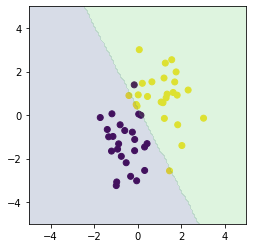

In [4]:
# Show the results with the given codes
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = LeastSquaresClassifier()
model.fit(X_train, y_train)
y = model.classify(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 1.2 Linear Regression

In [5]:
class LinearRegression(Regression):
    """
    Linear regression model
    y = X @ w
    t ~ N(t|X @ w, var)
    """

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        perform least squares fitting

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        """
        self.w = np.linalg.pinv(X) @ t
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X:np.ndarray, return_std:bool=False):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            samples to predict their output
        return_std : bool, optional
            returns standard deviation of each predition if True

        Returns
        -------
        y : (N,) np.ndarray
            prediction of each sample
        y_std : (N,) np.ndarray
            standard deviation of each predition
        """
        y = X @ self.w
        # Complete your code here

        return y


### 1.3 Logistic Regression

In [8]:
class LogisticRegression(Classifier):
    """
    Logistic regression model

    y = sigmoid(X @ w)
    t ~ Bernoulli(t|y)
    """

    @staticmethod
    def _sigmoid(a):
        return 1.0/(1+np.exp(-a))
        # Complete your code here
        # return the results with sigmoid function

    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=100):
        """
        maximum likelihood estimation of logistic regression model

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
            binary 0 or 1
        max_iter : int, optional
            maximum number of paramter update iteration (the default is 100)
        """
        w = np.zeros(np.size(X, 1))
        for _ in range(max_iter):
            w_prev = np.copy(w)
            y = self._sigmoid(X @ w)
            grad = X.T @ (y - t)
            hessian = (X.T * y * (1 - y)) @ X
            try:
                w -= np.linalg.solve(hessian, grad)
            except np.linalg.LinAlgError:
                break
            if np.allclose(w, w_prev):
                break
        self.w = w

    def proba(self, X:np.ndarray):
        """
        compute probability of input belonging class 1

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable

        Returns
        -------
        (N,) np.ndarray
            probability of positive
        """
        return self._sigmoid(X @ self.w)

    def classify(self, X:np.ndarray, threshold:float=0.5):
        """
        classify input data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable to be classified
        threshold : float, optional
            threshold of binary classification (default is 0.5)

        Returns
        -------
        (N,) np.ndarray
            binary class for each input
        """
        # Complete your code here
        y_pro = self.proba(X)
        y_pred = []
        for pro in y_pro:
            if pro > threshold:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return np.array(y_pred)


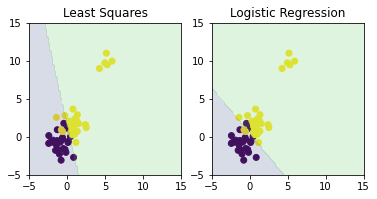

In [9]:
# Show the results with the given codes
x_train, y_train = create_toy_data(add_outliers=True)
x1_test, x2_test = np.meshgrid(np.linspace(-5, 15, 100), np.linspace(-5, 15, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

least_squares = LeastSquaresClassifier()
least_squares.fit(X_train, y_train)
y_ls = least_squares.classify(X_test)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_lr = logistic_regression.classify(X_test)

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_ls.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Least Squares")
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_lr.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 15)
plt.ylim(-5, 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Logistic Regression")
plt.show()

### 1.4 Softmax Regression

In [17]:
class SoftmaxRegression(Classifier):
    """
    Softmax regression model
    aka
    multinomial logistic regression,
    multiclass logistic regression,
    maximum entropy classifier.

    y = softmax(X @ W)
    t ~ Categorical(t|y)
    """

    @staticmethod
    def _softmax(a):
        # Complete your code here
        # 1.0/(1+np.exp(-a))
        sum_exp = np.sum(np.exp(a), axis = 1,keepdims = True)
        softmax = np.exp(a) / sum_exp
        return softmax
        # return np.exp(a) / np.sum(np.exp(a))
    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=100, learning_rate:float=0.1):
        """
        maximum likelihood estimation of the parameter

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) or (N, K) np.ndarray
            training dependent variable
            in class index or one-of-k encoding
        max_iter : int, optional
            maximum number of iteration (the default is 100)
        learning_rate : float, optional
            learning rate of gradient descent (the default is 0.1)
        """
        if t.ndim == 1:
            t = LabelTransformer().encode(t)
        self.n_classes = np.size(t, 1)
        W = np.zeros((np.size(X, 1), self.n_classes))
        for _ in range(max_iter):
            W_prev = np.copy(W)
            y = self._softmax(X @ W)
            grad = X.T @ (y - t)
            W -= learning_rate * grad
            if np.allclose(W, W_prev):
                break
        self.W = W

    def proba(self, X:np.ndarray):
        """
        compute probability of input belonging each class

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable

        Returns
        -------
        (N, K) np.ndarray
            probability of each class
        """
        return self._softmax(X @ self.W)

    def classify(self, X:np.ndarray):
        """
        classify input data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable to be classified

        Returns
        -------
        (N,) np.ndarray
            class index for each input
        """
        return np.argmax(self.proba(X), axis=-1)

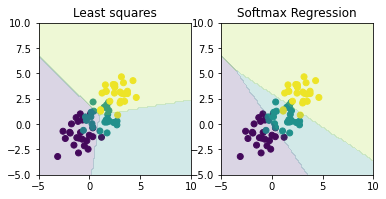

In [18]:
# Show the results with the given codes
x_train, y_train = create_toy_data(add_class=True)
x1_test, x2_test = np.meshgrid(np.linspace(-5, 10, 100), np.linspace(-5, 10, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

least_squares = LeastSquaresClassifier()
least_squares.fit(X_train, y_train)
y_ls = least_squares.classify(X_test)

logistic_regression = SoftmaxRegression()
logistic_regression.fit(X_train, y_train, max_iter=1000, learning_rate=0.01)
y_lr = logistic_regression.classify(X_test)

plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_ls.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Least squares")
plt.subplot(1, 2, 2)
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y_lr.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Softmax Regression")
plt.show()

### 1.5 Fisher's linear discriminant

In [36]:
class FishersLinearDiscriminant(Classifier):
    """
    Fisher's Linear discriminant model
    """

    def __init__(self, w:np.ndarray=None, threshold:float=None):
        self.w = w
        self.threshold = threshold

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        estimate parameter given training dataset

        Parameters
        ----------
        X : (N, D) np.ndarray
            training dataset independent variable
        t : (N,) np.ndarray
            training dataset dependent variable
            binary 0 or 1
        """
        # Complete your code here
        # 根据类别分个类
        index1 = np.array([index for (index, value) in enumerate(t) if value == 0])  # 获取类别1的indexs
        index2 = np.array([index for (index, value) in enumerate(t) if value == 1])  # 获取类别2的indexs

        c_1 = X[index1]   # 类别1的所有数据(x1, x2) in X_1
        c_2 = X[index2]   # 类别2的所有数据(x1, x2) in X_2
        
        cov_1, u1 = self.cal_cov_and_avg(c_1)
        cov_2, u2 = self.cal_cov_and_avg(c_2)
        s_w = cov_1 + cov_2          # 总类内离散度矩阵。
        u, s, v = np.linalg.svd(s_w) 
        s_w_inv = np.dot(np.dot(v.T, np.linalg.inv(np.diag(s))), u.T)
        self.w = np.dot(s_w_inv, u1 - u2)
        self.threshold = 0.03
    
    def cal_cov_and_avg(self,samples):
        """
        给定一个类别的数据，计算协方差矩阵和平均向量
        :param samples:
        :return:
        """
        u1 = np.mean(samples, axis=0)
        cov_m = np.zeros((samples.shape[1], samples.shape[1]))
        for s in samples:
            t = s - u1
            cov_m += t*t.reshape(2, 1)
        return cov_m, u1
    
    def transform(self, X:np.ndarray):
        """
        project data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable

        Returns
        -------
        y : (N,) np.ndarray
            projected data
        """
        return X @ self.w

    def classify(self, X:np.ndarray):
        """
        classify input data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable to be classified

        Returns
        -------
        (N,) np.ndarray
            binary class for each input
        """
        return (X @ self.w > self.threshold).astype(np.int)

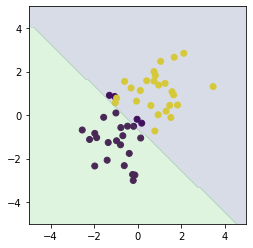

In [37]:
# Show the results with the given codes
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

model = FishersLinearDiscriminant()
model.fit(x_train, y_train)
y = model.classify(x_test)


plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), alpha=0.2, levels=np.linspace(0, 1, 3))
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## 2. Probabilistic Discriminative Models

### 2.1 Logistic Regression

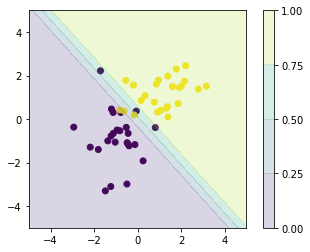

In [38]:
# Show the results with the given codes
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = LogisticRegression()
model.fit(X_train, y_train)
y = model.proba(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 2.2 Multiclass logistic regression

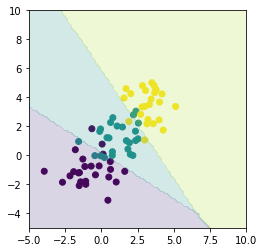

In [39]:
# Show the results with the given codes
x_train, y_train = create_toy_data(add_class=True)
x1, x2 = np.meshgrid(np.linspace(-5, 10, 100), np.linspace(-5, 10, 100))
x = np.array([x1, x2]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X = feature.transform(x)

model = SoftmaxRegression()
model.fit(X_train, y_train, max_iter=1000, learning_rate=0.01)
y = model.classify(X)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1, x2, y.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### 2.3 Bayesian Logistic Regression

In [40]:
class BayesianRegression(Regression):
    """
    Bayesian regression model

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None

    def _get_prior(self, ndim:int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim)

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        bayesian update of parameters given training dataset

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """

        mean_prev, precision_prev = self._get_prior(np.size(X, 1))

        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)

    def predict(self, X:np.ndarray, return_std:bool=False, sample_size:int=None):
        """
        return mean (and standard deviation) of predictive distribution

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            independent variable
        return_std : bool, optional
            flag to return standard deviation (the default is False)
        sample_size : int, optional
            number of samples to draw from the predictive distribution
            (the default is None, no sampling from the distribution)

        Returns
        -------
        y : (N,) np.ndarray
            mean of the predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of the predictive distribution
        y_sample : (N, sample_size) np.ndarray
            samples from the predictive distribution
        """

        if sample_size is not None:
            w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y_sample = X @ w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y


class BayesianLogisticRegression(LogisticRegression):
    """
    Logistic regression model

    w ~ Gaussian(0, alpha^(-1)I)
    y = sigmoid(X @ w)
    t ~ Bernoulli(t|y)
    """

    def __init__(self, alpha:float=1.):
        self.alpha = alpha
    
    def _sigmoid(self, a):
        return 1.0 / (1 + np.exp(-a))
    
    def fit(self, X:np.ndarray, t:np.ndarray, max_iter:int=100):
        """
        bayesian estimation of logistic regression model
        using Laplace approximation

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
            binary 0 or 1
        max_iter : int, optional
            maximum number of paramter update iteration (the default is 100)
        """
        # Complete your code here
        w = np.zeros(np.size(X, 1))
        eye = np.eye(np.size(X, 1))
        self.w_mean = np.copy(w)
        self.w_precision = self.alpha * eye
        for _ in range(max_iter):
            w_prev = np.copy(w)
            y = self._sigmoid(X @ w)
            grad = X.T @ (y - t) + self.w_precision @ (w - self.w_mean)
            hessian = (X.T * y * (1 - y)) @ X + self.w_precision
            try:
                w -= np.linalg.solve(hessian, grad)
            except np.linalg.LinAlgError:
                break
            if np.allclose(w, w_prev):
                break
        self.w_mean = w
        self.w_precision = hessian
        
    def proba(self, X:np.ndarray):
        """
        compute probability of input belonging class 1

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable

        Returns
        -------
        (N,) np.ndarray
            probability of positive
        """
        mu_a = X @ self.w_mean
        # Complete your code here
        # compute the var_a with numpy approaches
    
        var_a = np.sum(np.linalg.solve(self.w_precision, X.T).T * X, axis=1)
        return self._sigmoid(mu_a / np.sqrt(1 + np.pi * var_a / 8))

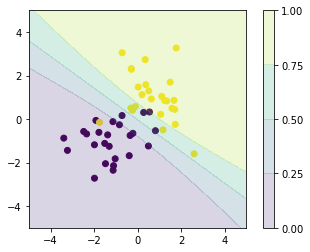

In [41]:
# Show the results with the given codes
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = BayesianLogisticRegression(alpha=1.)
model.fit(X_train, y_train, max_iter=1000)
y = model.proba(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()